### Build env for this notebook (temp. fix):

Running this on CPU with different environment, as tensorflow does not support 5000-series Nvidia GPUs yet.

The SVM notebooks have to be executed first, as they create and export the feature data. Then this notebook is run in the dnn_cpu environment, see Readme.md

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

import seaborn as sns
from subpred.evaluation import plot_results_long
from subpred.util import save_results, load_data
import random
import pickle

2025-06-06 17:48:20.902872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 17:48:20.923634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting random seeds for all libraries. The seed for TF is a starting seed, and will get incremented with each call of Dropout(). Therefore, the notebook has to be restarted to get the same results again.

In [ ]:
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Reading feature data from SVM notebook

In [ ]:
# importing feature data from SVM notebooks (they have to be run first)
import pickle

# with open("../data/tmp_data/svc_at_sugaramino_ml_data.pickle", "rb") as handle:
#     ml_datasets = pickle.load(handle)
with open(
    "../data/tmp_data/svc_at_sugaramino_outlier_removal_ml_data.pickle", "rb"
) as handle:
    ml_datasets_filtered = pickle.load(handle)

ml_datasets = ml_datasets_filtered

Trying three different architectures, as the features have different sizes ranging from 400 to 8000. High dropout of 0.5 should take care of most overfitting problems.

## Evaluation

In [6]:
for pos, ml_dataset in enumerate(ml_datasets):
    print(pos, ml_dataset.name, len(ml_dataset.feature_names))

0 DUMMY 1024
1 AAC 20
2 PAAC 400
3 AA_KMER3 8000
4 3Di_COMP 20
5 3Di_KMER2 400
6 3Di_KMER3 8000
7 COMB_KMER1 40
8 COMB_KMER2 800
9 COMB_KMER3 16000
10 PROTT5_AA 1024
11 PROSTT5_AA 1024
12 PROSTT5_3DI 1024
13 PSSM_50_1 400
14 PSSM_50_3 400
15 PSSM_90_1 400
16 PSSM_90_3 400
17 PSSM_META 1600
18 META 2020
19 META_STD 2020


Using the same metrics as with the SVM, to compare the results better

In [ ]:
scoring_outer = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Macro": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, average="macro"
    ),
    "F1 Amino Acid": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=0
    ),
    "F1 Sugar": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=1
    ),
}

Caching of results. A new test always needs a new test_name, otherwise it reads the old results.

In [ ]:
TEST_NAME = f"dnn_at_sugaramino_with_outlier_removal"
from subpred.dnn import crossval_dnn, create_model

from pathlib import Path

if Path(f"../data/results/{TEST_NAME}.pickle").exists():
    df_results_all = load_data(TEST_NAME, folder_path="../data/results")
else:
    results = [
        crossval_dnn(
            ml_dataset=ml_dataset,
            model_func=create_model,
            scores_dict=scoring_outer,
            splits=5,
            repeats=5,
            epochs=50,
            batch_size=8,
        )
        for ml_dataset in ml_datasets
    ]
    df_results_all = pd.concat(results)
    save_results(df_results_all, TEST_NAME, folder_path="../data/results")

## Plots

In [ ]:
# same plot as for svm, to compare
df_results_plot = df_results_all.copy()
df_results_plot.Feature = df_results_plot.Feature.str.replace("_", "-").replace(
    "PSSM-META", "MULTI-PSSM"
)
df_results_plot = df_results_plot[~df_results_plot.Feature.str.match(r"^PSSM-\d+")]
df_results_plot = df_results_plot[~df_results_plot.Feature.str.startswith("COMB")]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
    # "COMB-KMER1",
    # "COMB-KMER2",
    # "COMB-KMER3",
]

saves plot with test name and metrics in name

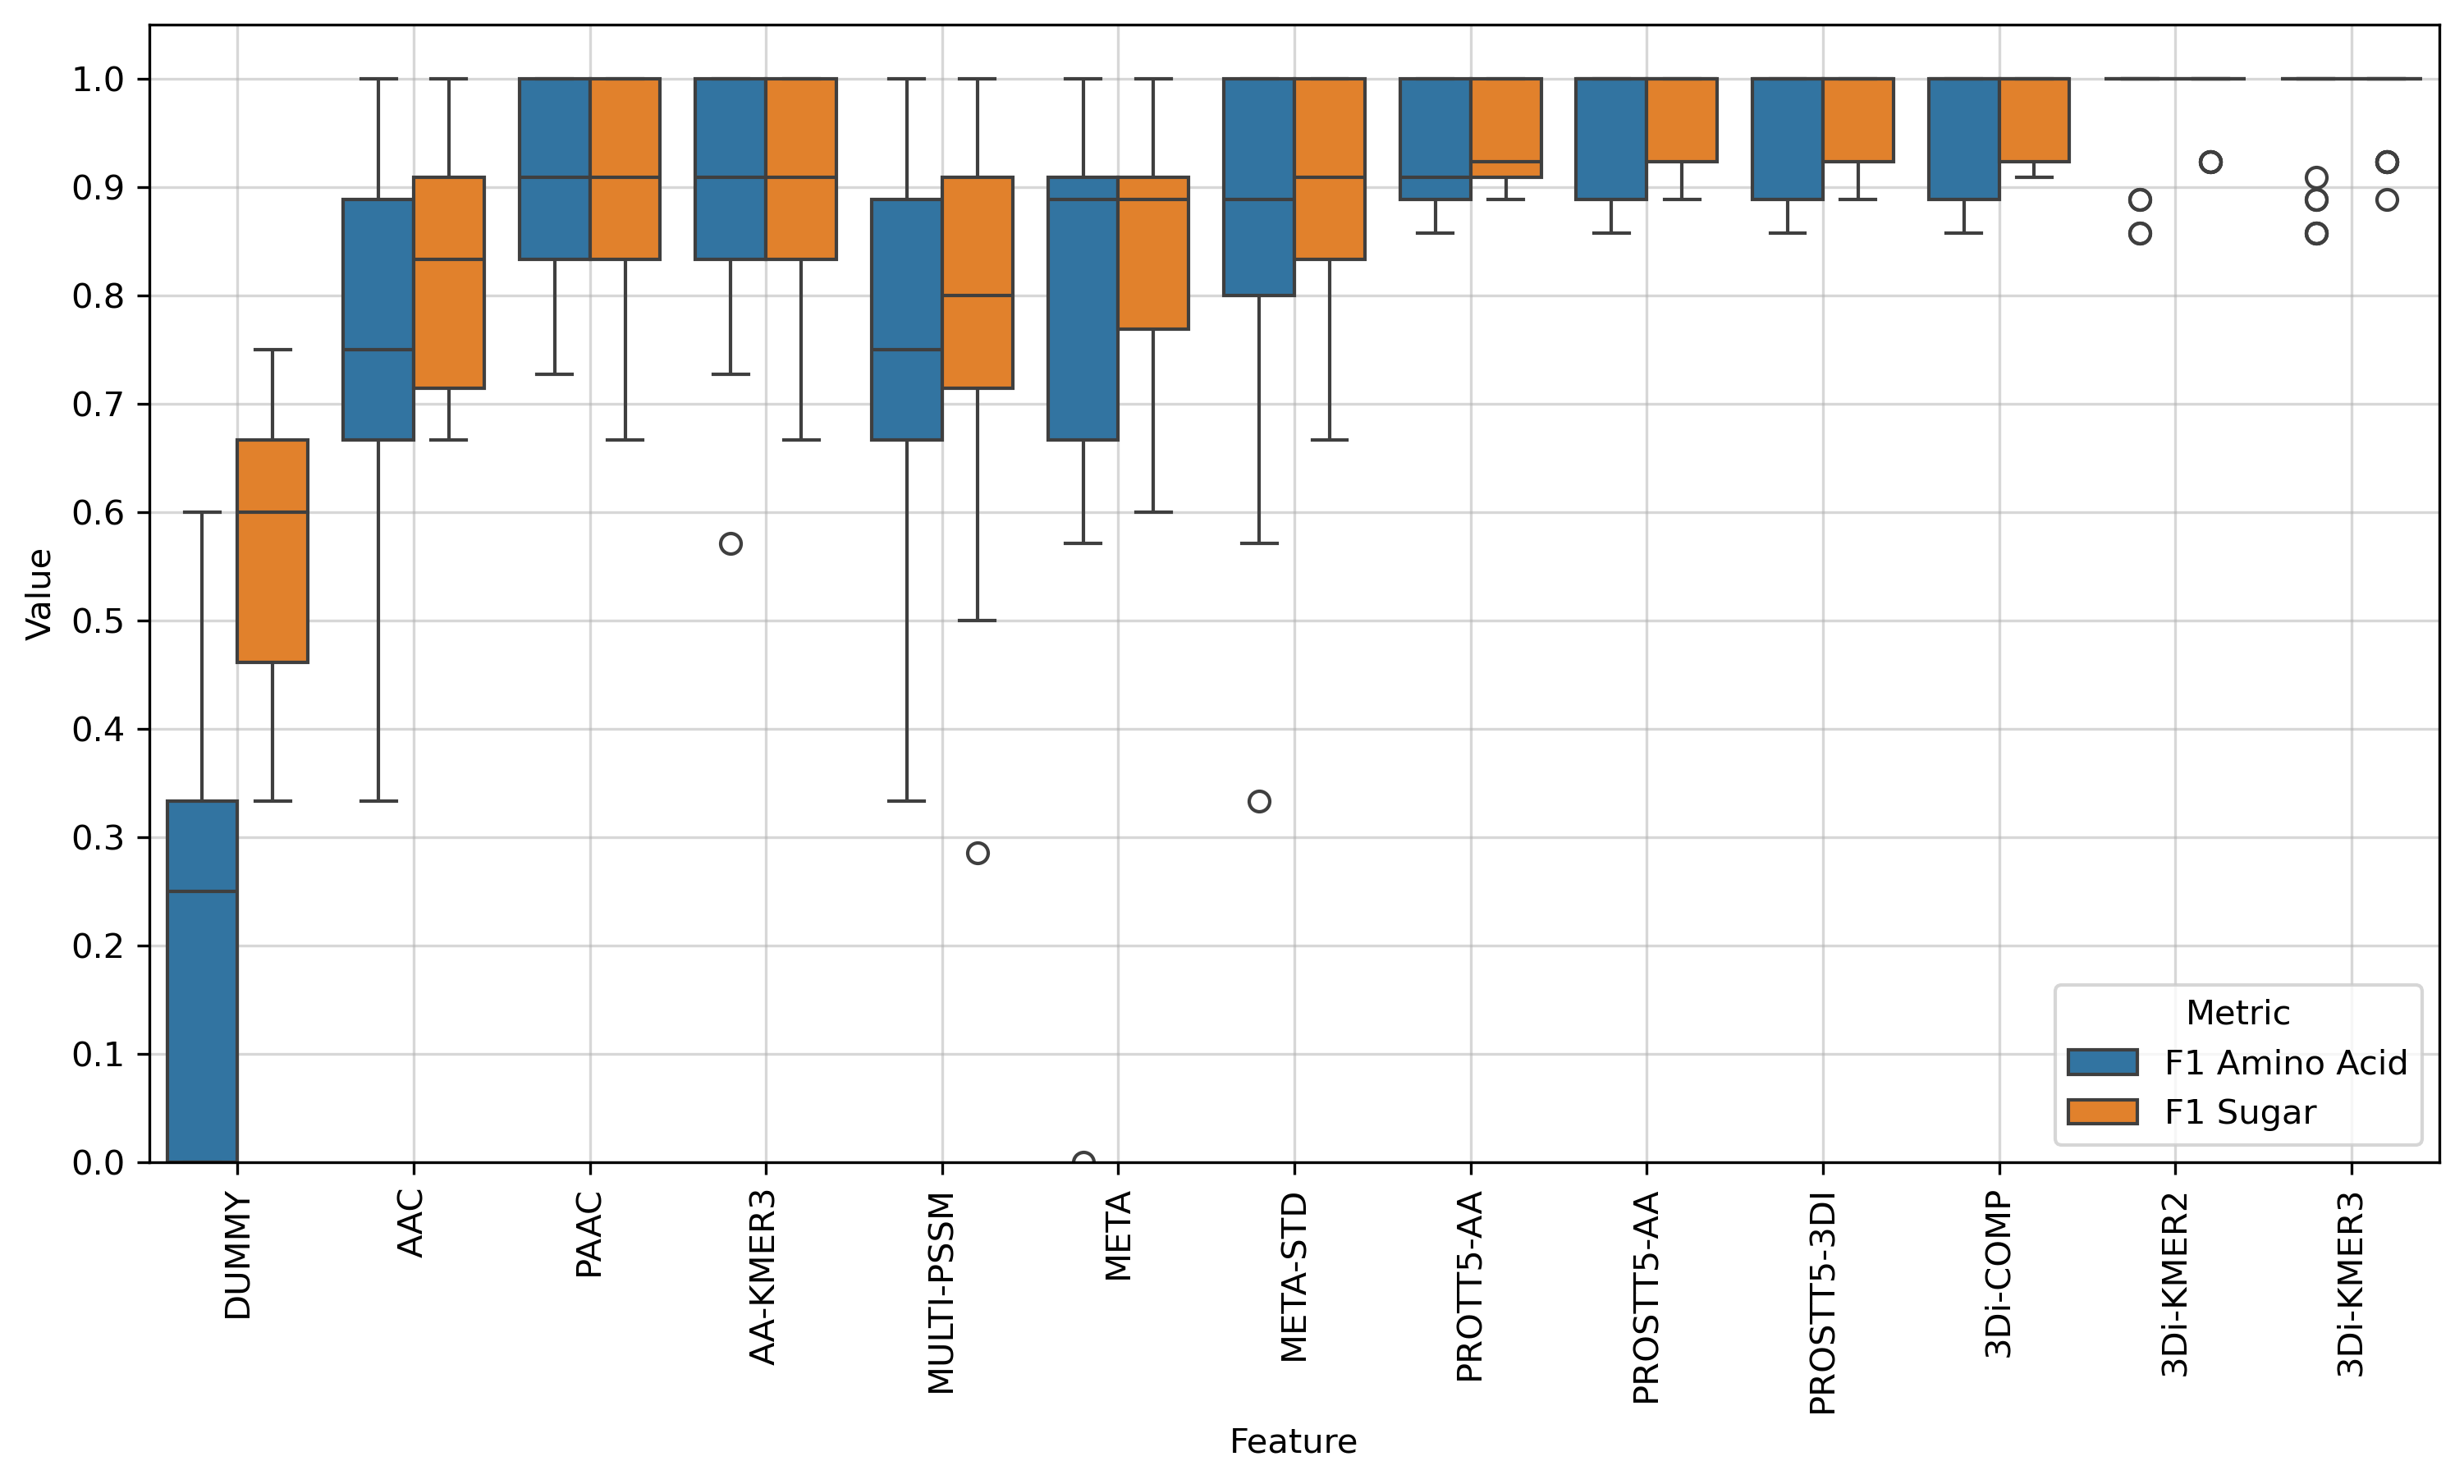

In [16]:
plot_results_long(
    df_results_long=df_results_plot,
    output_folder_path="../data/results/",
    test_name=TEST_NAME,
    plot_order=feature_order,
    metrics_include=["F1 Amino Acid", "F1 Sugar"],
)

## Tables

In [ ]:
df_table = df_results_all.copy()
df_table.Feature = df_table.Feature.str.replace("_", "-").replace(
    "PSSM-META", "MULTI-PSSM"
)
df_table = df_table[~df_table.Feature.str.match(r"^PSSM-\d+")]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
    "COMB-KMER1",
    "COMB-KMER2",
    "COMB-KMER3",
]

df_table_mean = (
    df_table.groupby(["Feature", "Metric"])
    .mean()
    .reset_index()
    .pivot(index="Feature", columns="Metric", values="Value")
)
df_table_std = (
    df_table.groupby(["Feature", "Metric"])
    .std()
    .reset_index()
    .pivot(index="Feature", columns="Metric", values="Value")
)

df_table_paper = (
    df_table_mean.map(lambda x: f"{x:.3f}").astype(str)
    + "±"
    + df_table_std.map(lambda x: f"{x:.3f}").astype(str)
)
df_table_paper = df_table_paper.loc[feature_order]
df_table_paper

Metric,Balanced Accuracy,F1 Amino Acid,F1 Macro,F1 Sugar
Feature,,,,
DUMMY,0.438±0.140,0.253±0.198,0.405±0.138,0.556±0.134
AAC,0.782±0.126,0.742±0.163,0.774±0.129,0.807±0.109
PAAC,0.904±0.078,0.893±0.089,0.897±0.085,0.900±0.084
AA-KMER3,0.899±0.085,0.886±0.107,0.892±0.093,0.897±0.086
MULTI-PSSM,0.780±0.130,0.751±0.166,0.761±0.149,0.772±0.163
META,0.830±0.142,0.788±0.218,0.813±0.165,0.838±0.131
META-STD,0.896±0.114,0.873±0.157,0.889±0.125,0.904±0.101
PROTT5-AA,0.938±0.054,0.929±0.061,0.939±0.051,0.948±0.044
PROSTT5-AA,0.959±0.052,0.954±0.059,0.959±0.051,0.965±0.045


In [18]:
df_table_paper.columns.name = None
print(
    df_table_paper.reset_index(drop=False)
    .drop("F1 Macro", axis=1)
    .to_latex(index=False)
    .replace("tabular", "tabular*")
    .replace("{llll}", "{\\textwidth}{@{\\extracolsep{\\fill}} lrrr}")
)

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}} lrrr}
\toprule
Feature & Balanced Accuracy & F1 Amino Acid & F1 Sugar \\
\midrule
DUMMY & 0.438±0.140 & 0.253±0.198 & 0.556±0.134 \\
AAC & 0.782±0.126 & 0.742±0.163 & 0.807±0.109 \\
PAAC & 0.904±0.078 & 0.893±0.089 & 0.900±0.084 \\
AA-KMER3 & 0.899±0.085 & 0.886±0.107 & 0.897±0.086 \\
MULTI-PSSM & 0.780±0.130 & 0.751±0.166 & 0.772±0.163 \\
META & 0.830±0.142 & 0.788±0.218 & 0.838±0.131 \\
META-STD & 0.896±0.114 & 0.873±0.157 & 0.904±0.101 \\
PROTT5-AA & 0.938±0.054 & 0.929±0.061 & 0.948±0.044 \\
PROSTT5-AA & 0.959±0.052 & 0.954±0.059 & 0.965±0.045 \\
PROSTT5-3DI & 0.959±0.052 & 0.954±0.059 & 0.965±0.045 \\
3Di-COMP & 0.951±0.054 & 0.942±0.062 & 0.960±0.043 \\
3Di-KMER2 & 0.982±0.042 & 0.980±0.048 & 0.988±0.029 \\
3Di-KMER3 & 0.973±0.049 & 0.970±0.055 & 0.980±0.037 \\
COMB-KMER1 & 0.939±0.088 & 0.926±0.112 & 0.944±0.077 \\
COMB-KMER2 & 0.943±0.055 & 0.937±0.061 & 0.942±0.057 \\
COMB-KMER3 & 0.935±0.064 & 0.926±0.079 & 0.937±0.058 \\
\b